# Used a ThunderSVM to increase the speed of training 

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

--2022-12-08 17:58:04--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.39.144
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/downloads/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2022-12-08 17:58:05--  https://developer.nvidia.com/downloads/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 404 Not Found
2022-12-08 17:58:06 ERROR 404: Not Found.

build  dist  drive  sample_data  thundersvm  thundersvm.egg-info
dpkg: error: cannot access archive 'cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb': No such file or d

# Adds GPU based learning for SVM and Processes Data

Requirements to run this on GPU to save memory contrainst

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!pip install thundersvm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Cleaned Version
! git clone https://github.com/Xtra-Computing/thundersvm.git
! cd thundersvm && mkdir build && cd build && cmake .. && make -j
! python /content/thundersvm/python/setup.py install


from sklearn.preprocessing import LabelEncoder


from importlib.machinery import SourceFileLoader
thundersvm = SourceFileLoader("thundersvm", "/content/thundersvm/python/thundersvm/thundersvm.py").load_module()
#from thundersvm import SVC
#clf = SVC()
#clf.fit(x, y)
svc = svm.SVC(verbose=True)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from thundersvm import SVC

Imports the Cleaned Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
#from google.colab import drive
from sklearn.preprocessing import LabelEncoder

#train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DC/data/train_data.csv', delimiter=',')
#test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DC/data/test_d#ata.csv', delimiter=',')
train_results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DC/data/train_results.csv', delimiter=',')

#X = train_data['text'].copy()
y = train_results['target'].copy()
#X_test = test_data['text'].copy()


le = LabelEncoder()
le.fit(y.unique())
y = le.transform(y) #positive:2, negative:0, neutral:1
y[:5]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


array([2, 0, 2, 2, 0])

In [ ]:
y.shape

(1040323,)

In [ ]:
with open(r'/content/drive/MyDrive/Colab Notebooks/DC/tokens.txt', 'r') as fp:
    output_list = fp.read().splitlines()

In [ ]:
output_list[0]

'getting'

In [ ]:
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    input_list = input_list.split(" ")
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams

for i in range(0, len(output_list)):
  print(ngrams(output_list[i]))
  if i == 5:
    break


[]
['apache feelin', 'feelin well', 'well morning', 'apache feelin well', 'feelin well morning']
['great friday', 'friday great', 'great tooooooo', 'great friday great', 'friday great tooooooo']
['dont wan', 'wan na', 'na sleep', 'sleep debated', 'debated end', 'end decided', 'decided perfect', 'perfect time', 'time bake', 'bake kidding', 'dont wan na', 'wan na sleep', 'na sleep debated', 'sleep debated end', 'debated end decided', 'end decided perfect', 'decided perfect time', 'perfect time bake', 'time bake kidding']
['twitter eat', 'eat dm', 'dm happy', 'twitter eat dm', 'eat dm happy']
['drivin north', 'north guess', 'guess miss', 'miss u', 'u tonite', 'drivin north guess', 'north guess miss', 'guess miss u', 'miss u tonite']


In [ ]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [ ]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [ ]:
vectorized_data = count_vectorizer.fit_transform(output_list[0:50000])
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

scaling = MinMaxScaler(feature_range=(-1,1)).fit(vectorized_data)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
test=indexed_data.toarray()

In [ ]:
np.unique(test[4])

array([0, 1, 4])

# Looking an an Example Plane

In [ ]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=1., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(indexed_data, y[0:50000])

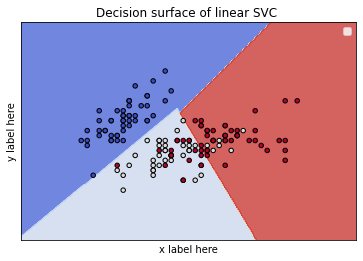

In [ ]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

In [ ]:
clf.score(indexed_data, y[0:5])

1.0

In [ ]:
 from sklearn.linear_model import SGDClassifier

clf= SGDClassifier(learning_rate = 'constant', eta0 = 0.1, shuffle = False)
# get x1, y1 as a new instance


In [ ]:
y

array([2, 0, 2, ..., 0, 2, 0])

In [ ]:

for i in range(0, 10)
  clf.partial_fit(indexed_data, y[0:500], classes=np.unique(y))
  clf.score(indexed_data, y[0:500])
# get x2, y2
# update accuracy if needed
#clf.partial_fit(x2, y2)

0.504

# If Processing is necessary

In [ ]:
# tokens[0]
# s = ''.join(tokens[0])
# out_list = []
# out_list.append(s)
# for i in range(0, len(tokens)):
#   s = ' '.join(tokens[i])
#   out_list.append(s)
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    out = []
    tweet = re.sub(r'http\S+', '', tweet )
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    #only_letters = re.sub(r'http\S+', '', )
    #only_letters = remove_urls(only_letters)
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    #lower_case = remove_urls(lower_case)
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    s = ' '.join(lemmas)
    out.append(s)
    return out
#test = X.apply(lambda x: normalizer(x))

# need to write this to a file 
#output_list = []
#for value in test:
 # output_list.append(value[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
with open(r'/content/drive/MyDrive/Colab Notebooks/DC/tokens.txt', 'w') as fp:
    for item in output_list:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


# How many features to use?

max_features = 3000 
max_features = 5000

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
tfvectorizer = TfidfVectorizer(min_df = 1e-6, ngram_range = (1,5),
                            lowercase =  True, use_idf= True, sublinear_tf = True, 
                            max_features=3000, 
                            stop_words = "english")

# Train the vectorizer on the training data and transform the training data and the test data
tfvectorizer.fit(output_list)
X_bag = tfvectorizer.fit_transform(output_list)

# SVM (71% validation accuracy)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
#output_list[0:10000]

cv = CountVectorizer(max_features = 3000)
x = cv.fit_transform(output_list).toarray()
sc = StandardScaler()
x_train = sc.fit_transform(x)
x_val = sc.transform(x_val)

In [ ]:
#sc = StandardScaler(with_mean=False)
#X_train_sc = sc.fit(x)
#x_train = X_train_sc.transform(x)

In [ ]:
with open(r'/content/drive/MyDrive/Colab Notebooks/DC/scaled_values.txt', 'w') as fp:
    for item in output_list:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

In [ ]:
x_train.shape

(100000, 3000)

In [ ]:
x_train.shape

(1040323, 3000)

In [ ]:
y.shape

(1040323,)

# Look a bit at the vocabulary 

In [ ]:
tfvectorizer.vocabulary_

In [ ]:
X_bag[0:10]

<10x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 43 stored elements in Compressed Sparse Row format>

# Fit the SVN Models

In [ ]:
SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_bag,y)

SVC(class_weight={}, kernel='linear')

In [ ]:
import pickle
filename = '/content/drive/MyDrive/Colab Notebooks/DC/svm_fullset_finalized_model.sav'
pickle.dump(SVM, open(filename, 'wb'))

In [ ]:
X_bag.shape

(50001, 5000)

In [ ]:
y.shape

(50000,)

# Train the SVM

In [2]:
# load the SVM: 

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_bag, y)

In [ ]:
predictions_SVM = SVM.predict(x_val[400000:500000])
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y[400000:500000])*100)

SVM Accuracy Score ->  71.90299999999999


# Loading the Model

In [ ]:
import pandas as pd
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DC/data/test_data_fix.csv', delimiter=',')['text']

In [ ]:
with open(r'/content/drive/MyDrive/Colab Notebooks/DC/tokens_text.txt', 'w') as fp:
    for item in test_data:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [ ]:
X_test = tfvectorizer.transform(test_data)

# Load the Trained Model (saved as a pickle file)

In [ ]:
import pickle
SVM = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/DC/svm_300000_finalized_model.sav', 'rb'))

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/DC/data/_svm.csv', 'a') as f: 
  count = 0 
  for value in len(X_test): 
    f.write("{},{}\n".format(int(count), int(SVM.predict(value)[0])))
    count = count + 1 
    if count % 500 ==0:
      print(count)

In [ ]:
output_list = []

# Other Variations of the SVM

In [ ]:
from sklearn.metrics import accuracy_score
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)

SVC(gamma='auto', kernel='linear')

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re
import string

from nltk.stem.porter import PorterStemmer

# Drop the two columns 
#df.drop(["text_wo_stopfreq", "text_wo_stopfreqrare"], axis=1, inplace=True) 

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


nltk.download('stopwords')
english_stopwords = stopwords.words("english")
other= ["..", "...", "....", "... ..."]
negative_words = ('no', 'not')
english_stopwords = [e for e in english_stopwords if e not in negative_words]

tweet_tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True,
    reduce_len=False
)

tokens = []
# for tweet in x_train:
# gets rid of URLs
X = X.apply(lambda x: re.sub(r'http\S+', '', x))
X = X.apply(lambda x: remove_urls(x))
#X = X.apply(lambda x: stem_words(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
for i, tweet in enumerate(X):
    #print(stem_wordstweet)
    #tweet = stem_words(tweet)
    #print(tweet)
    # brazilian
    # if 'traido' in tweet: 
    #   continue 
    # if 'îºî' in tweet: 
    #   continue
    # if 'cap des' in tweet: 
    #   continue
    # if "àª" in tweet: 
    #   continue
    
    string_encode = tweet.encode("ascii", "ignore")
    tweet = string_encode.decode()
    tweet = tweet.replace(r"tooooooo", "too")
    tweet = tweet.replace(";)", "smile")
    tweet = tweet.replace(":-D", "lovw")
    tweet = tweet.replace("=]", "love")
    tweet = tweet.replace("xxx", "kiss")
    tweet = tweet.replace("thx", "thanks")
    tweet = tweet.replace("hhhhhh", "")
    tweet = tweet.replace("ooooooooooooooooooooo", "")
    tweet = tweet.replace("f......g", "fucking")
    tweet = tweet.replace("aaaa", "a")
    token = tweet_tokenizer.tokenize(tweet)
    token_clened = [word for word in token if (word not in string.punctuation and word not in other)]
    #if i % 200 == 0:
    #  print(token_clened)
    #token_clened = [word for word in token if (word not in other and word not in string.punctuation)]
    #print(token_clened)
    tokens.append(token_clened)

In [ ]:
# tokenize the sentences
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
# fit on the 20000
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(tokens)
print(len(tokenizer.word_counts))

from keras.utils import to_categorical

y_train = to_categorical(y, 3)
#y_test = to_categorical(y_val, 3)


254585


In [ ]:
print(len(tokens))
train_text_vec = tokenizer.texts_to_sequences(tokens)
train_text_vec = pad_sequences(train_text_vec, maxlen=32)

1040323


In [ ]:
len(train_text_vec)

1040323

In [ ]:
y_train.shape

(1040323, 3)

In [ ]:
train_text_vec.shape

(2080643, 32)

Best Model